In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Swiler's file paths for each dataset. 
gdp_data = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/GDP.csv', parse_dates=['DATE'])
cpat_tax = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/CPATAX.csv', parse_dates=['DATE'])
durable_goods = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/manufacturers_new_orders_durable_goods_excluding_defense.csv', parse_dates=['DATE'])
housing_starts = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/housing start.csv', parse_dates=['DATE'])
industrial_production = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/industrial_production_total_index.csv', parse_dates=['DATE'])
personal_consumption = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/PCECTPI.csv', parse_dates=['DATE'])
t10y2y = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/T10Y2Y.csv', parse_dates=['DATE'])
sp500_vix = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/sp500_vix_quarterly.csv', parse_dates=['Date'])
gtrend_recession = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_recession.csv', parse_dates=['Month'])
gtrend_unemployment = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/gtrend_unemployment.csv', parse_dates=['Month'])
nonderiv_insider_activity = pd.read_csv('/Users/swilerboyd/Documents/GitHub/cs526_proj/datasets/quarterly/nonderiv_insider_activity.csv', parse_dates=['transactionDate'])

In [4]:
# Merge datasets on their respective date columns
data = gdp_data.copy()  # Start with GDP data

# Merge other datasets using 'DATE' or appropriate columns
data = data.merge(cpat_tax, on='DATE', how='left')
data = data.merge(durable_goods, on='DATE', how='left')
data = data.merge(housing_starts, on='DATE', how='left')
data = data.merge(industrial_production, on='DATE', how='left')
data = data.merge(personal_consumption, on='DATE', how='left')
data = data.merge(t10y2y, on='DATE', how='left')
data = data.merge(sp500_vix.rename(columns={'Date': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_recession.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(gtrend_unemployment.rename(columns={'Month': 'DATE'}), on='DATE', how='left')
data = data.merge(nonderiv_insider_activity.rename(columns={'transactionDate': 'DATE'}), on='DATE', how='left')


Logistic Regression Model 1 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.86        87
         1.0       0.14      0.50      0.21         6

    accuracy                           0.76        93
   macro avg       0.55      0.64      0.54        93
weighted avg       0.90      0.76      0.82        93



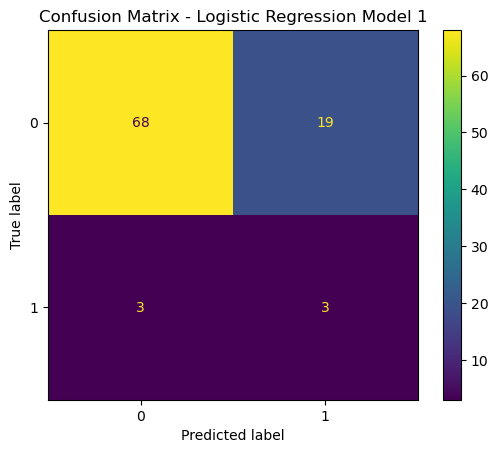

Logistic Regression Model 1 likelihood of recession in Q1 2022: 0.90%


In [5]:
# Model 1 - more observations, less variables to train on. Predicting 2022Q1 recession
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define the target variable and calculate differences for features
data['GDP_diff'] = data['GDP'].diff()
data['Recession'] = np.where(data['GDP_diff'] < 0, 1, 0)
data['Recession_next_quarter'] = data['Recession'].shift(-1)

data['CPATAX_diff'] = data['CPATAX'].diff()
data['PCECTPI_diff'] = data['PCECTPI'].diff()
data['IPB50001SQ_diff'] = data['IPB50001SQ'].diff()

# Model 1 Feature Set
X_model1 = data[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff']]
Xy_model1 = pd.concat([X_model1, data['Recession_next_quarter']], axis=1).dropna()
X_model1_cleaned = Xy_model1.drop(columns=['Recession_next_quarter'])
y_model1_cleaned = Xy_model1['Recession_next_quarter']

# Scale the features
scaler = StandardScaler()
X_model1_scaled = scaler.fit_transform(X_model1_cleaned)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_model1_scaled, y_model1_cleaned, test_size=0.3, random_state=42, stratify=y_model1_cleaned)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train1, y_train1)

# Evaluate the model
y_pred_model1 = logreg.predict(X_test1)
print("\nLogistic Regression Model 1 Report (Test Set):\n", classification_report(y_test1, y_pred_model1, zero_division=0))
cm_model1 = confusion_matrix(y_test1, y_pred_model1)
ConfusionMatrixDisplay(confusion_matrix=cm_model1).plot()
plt.title("Confusion Matrix - Logistic Regression Model 1")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_q4_2021 = data[(data['DATE'] >= '2021-10-01') & (data['DATE'] < '2022-01-01')].copy()
last_row_q4_2021 = test_data_q4_2021.iloc[-1]



# Step 3: Calculate differenced features for Q1 2022
X_test_model1_2022 = pd.DataFrame([{
    'CPATAX_diff': data[data['DATE'] == '2022-01-01']['CPATAX'].values[0] - last_row_q4_2021['CPATAX'],
    'PCECTPI_diff': data[data['DATE'] == '2022-01-01']['PCECTPI'].values[0] - last_row_q4_2021['PCECTPI'],
    'IPB50001SQ_diff': data[data['DATE'] == '2022-01-01']['IPB50001SQ'].values[0] - last_row_q4_2021['IPB50001SQ']
}])

# Step 4: Scale the test features using the scaler from training
X_test_model1_scaled = scaler.transform(X_test_model1_2022)

# Step 5: Make predictions for Q1 2022
y_pred_proba_model1_Q1_2022 = logreg.predict_proba(X_test_model1_scaled)[:, 1]  # Probability of class 1 (recession)

# Print the percentage likelihood of a recession for Q1 2022
print(f"Logistic Regression Model 1 likelihood of recession in Q1 2022: {y_pred_proba_model1_Q1_2022[0] * 100:.2f}%")



Logistic Regression Model 3 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90        22
         1.0       0.25      0.50      0.33         2

    accuracy                           0.83        24
   macro avg       0.60      0.68      0.62        24
weighted avg       0.89      0.83      0.86        24



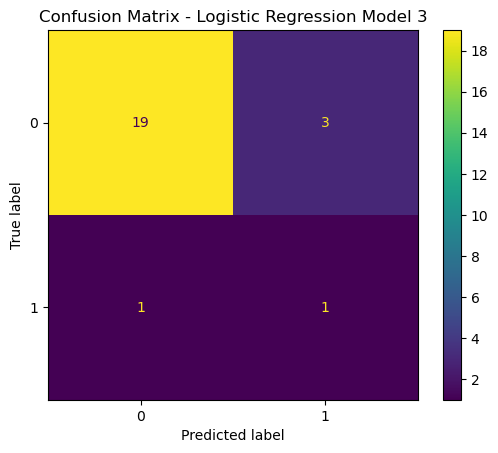

Logistic Regression Model 3 likelihood of recession for entry 1 in Q1 2022: 2.62%


In [11]:
#Model 3, novel data sources. Less observations on train on,  Predicting 2022Q1 recession
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define the target variable and calculate differences for features
data['GDP_diff'] = data['GDP'].diff()
data['Recession'] = np.where(data['GDP_diff'] < 0, 1, 0)
data['Recession_next_quarter'] = data['Recession'].shift(-1)

# Calculate differences for each variable
data['CPATAX_diff'] = data['CPATAX'].diff()
data['PCECTPI_diff'] = data['PCECTPI'].diff()
data['IPB50001SQ_diff'] = data['IPB50001SQ'].diff()
data['HOUST_diff'] = data['HOUST'].diff()
data['ADXDNO_diff'] = data['ADXDNO'].diff()
data['T10Y2Y_diff'] = data['T10Y2Y'].diff()
data['S&P 500_diff'] = data['S&P 500'].diff()
data['VIX_diff'] = data['VIX'].diff()
data['recession_diff'] = data['recession: (United States)'].diff()
data['unemployment_diff'] = data['Unemployment benefits: (United States)'].diff()
data['net_buys_diff'] = data['net_buys'].diff()

# Model 3 Feature Set
X_model3 = data[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                 'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
Xy_model3 = pd.concat([X_model3, data['Recession_next_quarter']], axis=1).dropna()
X_model3_cleaned = Xy_model3.drop(columns=['Recession_next_quarter'])
y_model3_cleaned = Xy_model3['Recession_next_quarter']

# Scale the features
scaler = StandardScaler()
X_model3_scaled = scaler.fit_transform(X_model3_cleaned)

# Train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_model3_scaled, y_model3_cleaned, test_size=0.3, random_state=42, stratify=y_model3_cleaned)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train3, y_train3)

# Evaluate the model
y_pred_model3 = logreg.predict(X_test3)
print("\nLogistic Regression Model 3 Report (Test Set):\n", classification_report(y_test3, y_pred_model3, zero_division=0))
cm_model3 = confusion_matrix(y_test3, y_pred_model3)
ConfusionMatrixDisplay(confusion_matrix=cm_model3).plot()
plt.title("Confusion Matrix - Logistic Regression Model 3")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_2022_Q1 = data[(data['DATE'] >= '2021-10-01') & (data['DATE'] < '2022-04-01')].copy()

# Create differenced variables for Q1 2022 data
test_data_2022_Q1['CPATAX_diff'] = test_data_2022_Q1['CPATAX'].diff()
test_data_2022_Q1['PCECTPI_diff'] = test_data_2022_Q1['PCECTPI'].diff()
test_data_2022_Q1['IPB50001SQ_diff'] = test_data_2022_Q1['IPB50001SQ'].diff()
test_data_2022_Q1['HOUST_diff'] = test_data_2022_Q1['HOUST'].diff()
test_data_2022_Q1['ADXDNO_diff'] = test_data_2022_Q1['ADXDNO'].diff()
test_data_2022_Q1['T10Y2Y_diff'] = test_data_2022_Q1['T10Y2Y'].diff()
test_data_2022_Q1['S&P 500_diff'] = test_data_2022_Q1['S&P 500'].diff()
test_data_2022_Q1['VIX_diff'] = test_data_2022_Q1['VIX'].diff()
test_data_2022_Q1['recession_diff'] = test_data_2022_Q1['recession: (United States)'].diff()
test_data_2022_Q1['unemployment_diff'] = test_data_2022_Q1['Unemployment benefits: (United States)'].diff()
test_data_2022_Q1['net_buys_diff'] = test_data_2022_Q1['net_buys'].diff()

# Drop rows outside Q1 2022 to ensure we're predicting for Q1 2022 only
test_data_2022_Q1 = test_data_2022_Q1[test_data_2022_Q1['DATE'] >= '2022-01-01']
test_data_2022_Q1.dropna(inplace=True)

if not test_data_2022_Q1.empty:
    # Model 3 Prediction for Q1 2022
    X_test_model3_2022 = test_data_2022_Q1[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                                            'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
    X_test_model3_scaled = scaler.transform(X_test_model3_2022)
    
    # Get probability predictions for Q1 2022
    y_pred_proba_model3_Q1_2022 = logreg.predict_proba(X_test_model3_scaled)[:, 1]  # Probability of class 1 (recession)
    
    # Print the percentage likelihood of a recession for each prediction
    for idx, prob in enumerate(y_pred_proba_model3_Q1_2022):
        print(f"Logistic Regression Model 3 likelihood of recession for entry {idx + 1} in Q1 2022: {prob * 100:.2f}%")
else:
    print("No data available for Q1 2022 after differencing.")



Logistic Regression Model 1 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.86        87
         1.0       0.14      0.50      0.21         6

    accuracy                           0.76        93
   macro avg       0.55      0.64      0.54        93
weighted avg       0.90      0.76      0.82        93



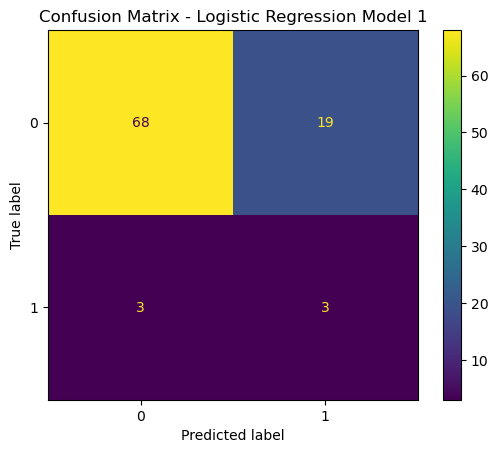

Logistic Regression Model 1 likelihood of recession in Q4 2021: 0.67%


In [7]:
# Model 1 - more observations, less variables to train on. Predicting 2021Q4 recession
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define the target variable and calculate differences for features
data['GDP_diff'] = data['GDP'].diff()
data['Recession'] = np.where(data['GDP_diff'] < 0, 1, 0)
data['Recession_next_quarter'] = data['Recession'].shift(-1)

data['CPATAX_diff'] = data['CPATAX'].diff()
data['PCECTPI_diff'] = data['PCECTPI'].diff()
data['IPB50001SQ_diff'] = data['IPB50001SQ'].diff()

# Model 1 Feature Set
X_model1 = data[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff']]
Xy_model1 = pd.concat([X_model1, data['Recession_next_quarter']], axis=1).dropna()
X_model1_cleaned = Xy_model1.drop(columns=['Recession_next_quarter'])
y_model1_cleaned = Xy_model1['Recession_next_quarter']

# Scale the features
scaler = StandardScaler()
X_model1_scaled = scaler.fit_transform(X_model1_cleaned)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_model1_scaled, y_model1_cleaned, test_size=0.3, random_state=42, stratify=y_model1_cleaned)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train1, y_train1)

# Evaluate the model
y_pred_model1 = logreg.predict(X_test1)
print("\nLogistic Regression Model 1 Report (Test Set):\n", classification_report(y_test1, y_pred_model1, zero_division=0))
cm_model1 = confusion_matrix(y_test1, y_pred_model1)
ConfusionMatrixDisplay(confusion_matrix=cm_model1).plot()
plt.title("Confusion Matrix - Logistic Regression Model 1")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_q4_2021 = data[(data['DATE'] >= '2021-07-01') & (data['DATE'] < '2021-10-01')].copy()
last_row_q4_2021 = test_data_q4_2021.iloc[-1]

# Step 3: Calculate differenced features for Q1 2022
X_test_model1_2022 = pd.DataFrame([{
    'CPATAX_diff': data[data['DATE'] == '2021-10-01']['CPATAX'].values[0] - last_row_q4_2021['CPATAX'],
    'PCECTPI_diff': data[data['DATE'] == '2021-10-01']['PCECTPI'].values[0] - last_row_q4_2021['PCECTPI'],
    'IPB50001SQ_diff': data[data['DATE'] == '2021-10-01']['IPB50001SQ'].values[0] - last_row_q4_2021['IPB50001SQ']
}])

# Step 4: Scale the test features using the scaler from training
X_test_model1_scaled = scaler.transform(X_test_model1_2022)

# Step 5: Make predictions for Q1 2022
y_pred_proba_model1_Q1_2022 = logreg.predict_proba(X_test_model1_scaled)[:, 1]  # Probability of class 1 (recession)

# Print the percentage likelihood of a recession for Q1 2022
print(f"Logistic Regression Model 1 likelihood of recession in Q4 2021: {y_pred_proba_model1_Q1_2022[0] * 100:.2f}%")



Logistic Regression Model 3 Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90        22
         1.0       0.25      0.50      0.33         2

    accuracy                           0.83        24
   macro avg       0.60      0.68      0.62        24
weighted avg       0.89      0.83      0.86        24



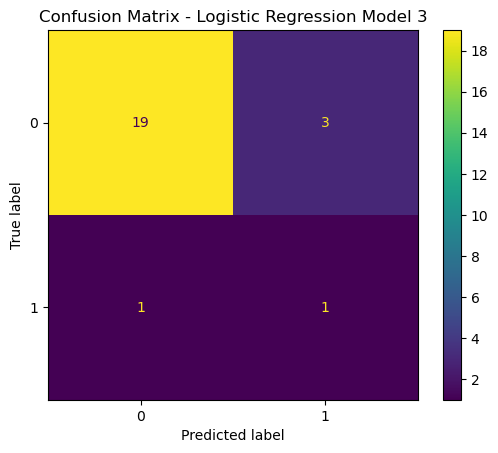

Logistic Regression Model 3 likelihood of recession in Q4 2021: 30.23%


In [14]:
#Model 3, novel data sources. Less observations on train on, more variables. Predicting 2021Q4 recession
# Ensure 'DATE' is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Step 1: Define the target variable and calculate differences for features
data['GDP_diff'] = data['GDP'].diff()
data['Recession'] = np.where(data['GDP_diff'] < 0, 1, 0)
data['Recession_next_quarter'] = data['Recession'].shift(-1)

# Calculate differences for each variable
data['CPATAX_diff'] = data['CPATAX'].diff()
data['PCECTPI_diff'] = data['PCECTPI'].diff()
data['IPB50001SQ_diff'] = data['IPB50001SQ'].diff()
data['HOUST_diff'] = data['HOUST'].diff()
data['ADXDNO_diff'] = data['ADXDNO'].diff()
data['T10Y2Y_diff'] = data['T10Y2Y'].diff()
data['S&P 500_diff'] = data['S&P 500'].diff()
data['VIX_diff'] = data['VIX'].diff()
data['recession_diff'] = data['recession: (United States)'].diff()
data['unemployment_diff'] = data['Unemployment benefits: (United States)'].diff()
data['net_buys_diff'] = data['net_buys'].diff()

# Model 3 Feature Set
X_model3 = data[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                 'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
Xy_model3 = pd.concat([X_model3, data['Recession_next_quarter']], axis=1).dropna()
X_model3_cleaned = Xy_model3.drop(columns=['Recession_next_quarter'])
y_model3_cleaned = Xy_model3['Recession_next_quarter']

# Scale the features
scaler = StandardScaler()
X_model3_scaled = scaler.fit_transform(X_model3_cleaned)

# Train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_model3_scaled, y_model3_cleaned, test_size=0.3, random_state=42, stratify=y_model3_cleaned)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train3, y_train3)

# Evaluate the model
y_pred_model3 = logreg.predict(X_test3)
print("\nLogistic Regression Model 3 Report (Test Set):\n", classification_report(y_test3, y_pred_model3, zero_division=0))
cm_model3 = confusion_matrix(y_test3, y_pred_model3)
ConfusionMatrixDisplay(confusion_matrix=cm_model3).plot()
plt.title("Confusion Matrix - Logistic Regression Model 3")
plt.show()

# Step 2: Prepare Q1 2022 data for prediction
# Include the last row from Q4 2021 to calculate differencing for Q1 2022
test_data_2022_Q1 = data[(data['DATE'] >= '2021-07-01') & (data['DATE'] < '2022-01-01')].copy()

# Create differenced variables for Q1 2022 data
test_data_2022_Q1['CPATAX_diff'] = test_data_2022_Q1['CPATAX'].diff()
test_data_2022_Q1['PCECTPI_diff'] = test_data_2022_Q1['PCECTPI'].diff()
test_data_2022_Q1['IPB50001SQ_diff'] = test_data_2022_Q1['IPB50001SQ'].diff()
test_data_2022_Q1['HOUST_diff'] = test_data_2022_Q1['HOUST'].diff()
test_data_2022_Q1['ADXDNO_diff'] = test_data_2022_Q1['ADXDNO'].diff()
test_data_2022_Q1['T10Y2Y_diff'] = test_data_2022_Q1['T10Y2Y'].diff()
test_data_2022_Q1['S&P 500_diff'] = test_data_2022_Q1['S&P 500'].diff()
test_data_2022_Q1['VIX_diff'] = test_data_2022_Q1['VIX'].diff()
test_data_2022_Q1['recession_diff'] = test_data_2022_Q1['recession: (United States)'].diff()
test_data_2022_Q1['unemployment_diff'] = test_data_2022_Q1['Unemployment benefits: (United States)'].diff()
test_data_2022_Q1['net_buys_diff'] = test_data_2022_Q1['net_buys'].diff()

# Drop rows outside Q1 2022 to ensure we're predicting for Q1 2022 only
test_data_2022_Q1 = test_data_2022_Q1[test_data_2022_Q1['DATE'] >= '2021-10-01']
test_data_2022_Q1.dropna(inplace=True)

if not test_data_2022_Q1.empty:
    # Model 3 Prediction for Q1 2022
    X_test_model3_2022 = test_data_2022_Q1[['CPATAX_diff', 'PCECTPI_diff', 'IPB50001SQ_diff', 'HOUST_diff', 'ADXDNO_diff', 
                                            'T10Y2Y_diff', 'S&P 500_diff', 'VIX_diff', 'recession_diff', 'unemployment_diff', 'net_buys_diff']]
    X_test_model3_scaled = scaler.transform(X_test_model3_2022)
    
    # Get probability predictions for Q1 2022
    y_pred_proba_model3_Q1_2022 = logreg.predict_proba(X_test_model3_scaled)[:, 1]  # Probability of class 1 (recession)
    
    # Print the percentage likelihood of a recession for each prediction
    for idx, prob in enumerate(y_pred_proba_model3_Q1_2022):
        print(f"Logistic Regression Model 3 likelihood of recession in Q4 2021: {prob * 100:.2f}%")
else:
    print("No data available for Q1 2022 after differencing.")
